# LASSO - L1 Regularized Regression (An SGD Wrapper)

In [1]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../..')
from zwml.linear_models import sgd_regressor

class lasso_regressor(sgd_regressor):
    
    def __init__(self, n_iter=100, alpha=0.01, verbose=False, return_steps=False, fit_intercept=True, 
                 dynamic=True, loss='ols', epsilon=0.1, lamb=1e-6, l1_perc = 0.5):
        """
        Lasso Regressor - This is a wrapper on the SGD class where the regularization is set
        to the L1 Norm. All other functionality is the same as the SGD class.
        ---
        KWargs:
        
        n_iter: number of epochs to run in while fitting to the data. Total number of steps
        will be n_iter*X.shape[0]. 
        
        alpha: The learning rate. Moderates the step size during the gradient descent algorithm.
        
        verbose: Whether to print out coefficient information during the epochs
        
        return_steps: If True, fit returns a list of the coefficients at each update step for diagnostics
        
        fit_intercept: If True, an extra coefficient is added with no associated feature to act as the
                       base prediction if all X are 0.
                       
        dynamic: If true, an annealing scedule is used to scale the learning rate. 
        
        lamb: Stands for lambda. Sets the strength of the regularization. Large lambda causes large
              regression. If regularization is off, this does not apply to anything.
              
        l1_perc: If using elastic net, this variable sets what portion of the penalty is L1 vs L2. 
                 If regularize='EN' and l1_perc = 1, equivalent to regularize='L1'. If 
                 regularize='EN' and l1_perc = 0, equivalent to regulzarize='L2'.
        """
        self.coef_ = None
        self.trained = False
        self.n_iter = n_iter
        self.alpha_ = alpha
        self.verbosity = verbose
        self._return_steps = return_steps
        self._fit_intercept = fit_intercept
        self._next_alpha_shift = 0.1 # Only used if dynamic=True
        self._dynamic = dynamic
        self._regularize = 'L1'
        self._lamb = lamb
        self._l1_perc = l1_perc

# Let's Gen some data to see how it behaves

In [3]:
def gen_data(rows = 200, gen_coefs = [2,4], gen_inter = 0):
    X = np.random.rand(rows,len(gen_coefs))
    y = np.sum(np.tile(np.array(gen_coefs),(X.shape[0],1))*X,axis=1)
    y = y + np.random.normal(0,0.5, size=X.shape[0])
    y = y + gen_inter
    return X, y

actual_coefs = [10,8,9,10,11]
X, y = gen_data(gen_coefs=actual_coefs[1:], gen_inter=actual_coefs[0])

It will work with Pandas or Numpy arrays. Let's play with Pandas for now.

In [4]:
import pandas as pd
cols = []
for i in range(X.shape[1]):
    cols.append('X'+str(i))
data = pd.DataFrame(X, columns=cols)
data['y'] = y
data.head()

,X0,X1,X2,X3,y
0,0.173416,0.451729,0.957330,0.672791,30.706823
1,0.348086,0.823259,0.893150,0.343698,32.986387
2,0.313830,0.836898,0.529332,0.285011,27.914057
3,0.852465,0.103948,0.440520,0.837927,31.565024
4,0.455339,0.923958,0.376812,0.634280,32.750732


In [5]:
sgd = lasso_regressor(n_iter=500, alpha=1e-3, verbose=False, dynamic=False, return_steps=True, lamb=1e-6)

In [6]:
steps = sgd.fit(data.iloc[:,:-1],data.iloc[:,-1])

In [7]:
sgd.coef_

array([ 10.18776236,   7.9237556 ,   8.92287078,   9.79356877,  10.86531819])

In [8]:
test_X, test_y = gen_data(rows=200, gen_coefs=actual_coefs[1:], gen_inter=actual_coefs[0])
pred_y = sgd.predict(test_X)
test_err = pred_y - test_y

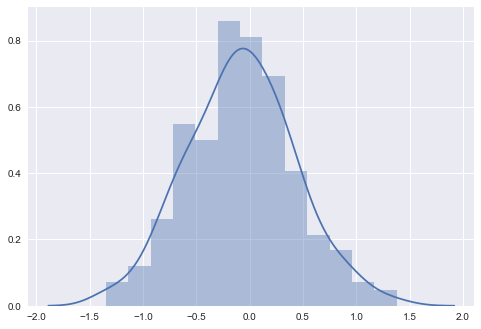

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

sns.distplot(test_err);

In [10]:
from scipy.stats import normaltest
print(normaltest(test_err))

NormaltestResult(statistic=0.21477992751931113, pvalue=0.89817534885201777)


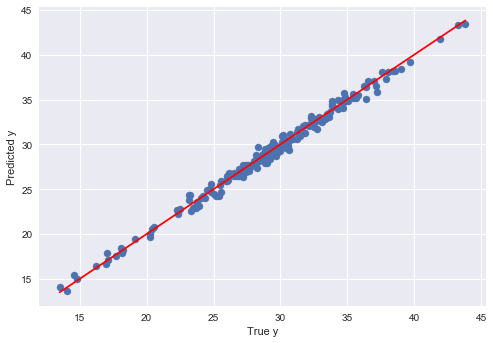

In [11]:
plt.scatter(test_y, pred_y, s=50)
temp = np.linspace(min(test_y),max(test_y),100)
plt.plot(temp,temp,'r-')
plt.xlabel("True y")
plt.ylabel("Predicted y");

## Let's look at how the optimization looks in the Coefficient Space!

In [19]:
def plot_beta_space(steps, components = (0,1), last_300=False, zoom=False):
    plt.figure(figsize=(20,16))
    try:
        B0 = np.array(steps).T[components[0]]
        B1 = np.array(steps).T[components[1]]
    except:
        print("Couldn't find those components, defaulting to (0,1)")
        B0 = np.array(steps).T[0]
        B1 = np.array(steps).T[1]
    if last_300:
        steps_to_show=-300
        skip = 2
        plt.scatter(B0[steps_to_show::skip],B1[steps_to_show::skip],c=plt.cm.rainbow(np.linspace(0,1,len(B0[steps_to_show::skip]))));
        plt.scatter(steps[steps_to_show][0],steps[steps_to_show][1],c='r',marker='x', s=400,label='Start')
        plt.scatter(steps[-1][0],steps[-1][1],c='k',marker='x', s=400,label='End')
        plt.title("Movement in the Coefficient Space, Last "+str(-steps_to_show)+" steps!",fontsize=32);
    else: 
        plt.scatter(B0[::25],B1[::25],c=plt.cm.rainbow(np.linspace(0,1,len(B0[::25]))));
        plt.scatter(steps[0][0],steps[0][1],c='r',marker='x', s=400,label='Start')
        plt.scatter(steps[-1][0],steps[-1][1],c='k',marker='x', s=400,label='End')
        plt.title("Movement in the Coefficient Space",fontsize=32);
    plt.legend(fontsize=32, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');
    plt.xlabel("B"+str(components[0]),fontsize=26)
    plt.ylabel("B"+str(components[1]),fontsize=26);
    if zoom:
        plt.ylim(min(B1[steps_to_show::skip]), max(B1[steps_to_show::skip]))
        plt.xlim(min(B0[steps_to_show::skip]), max(B0[steps_to_show::skip]));

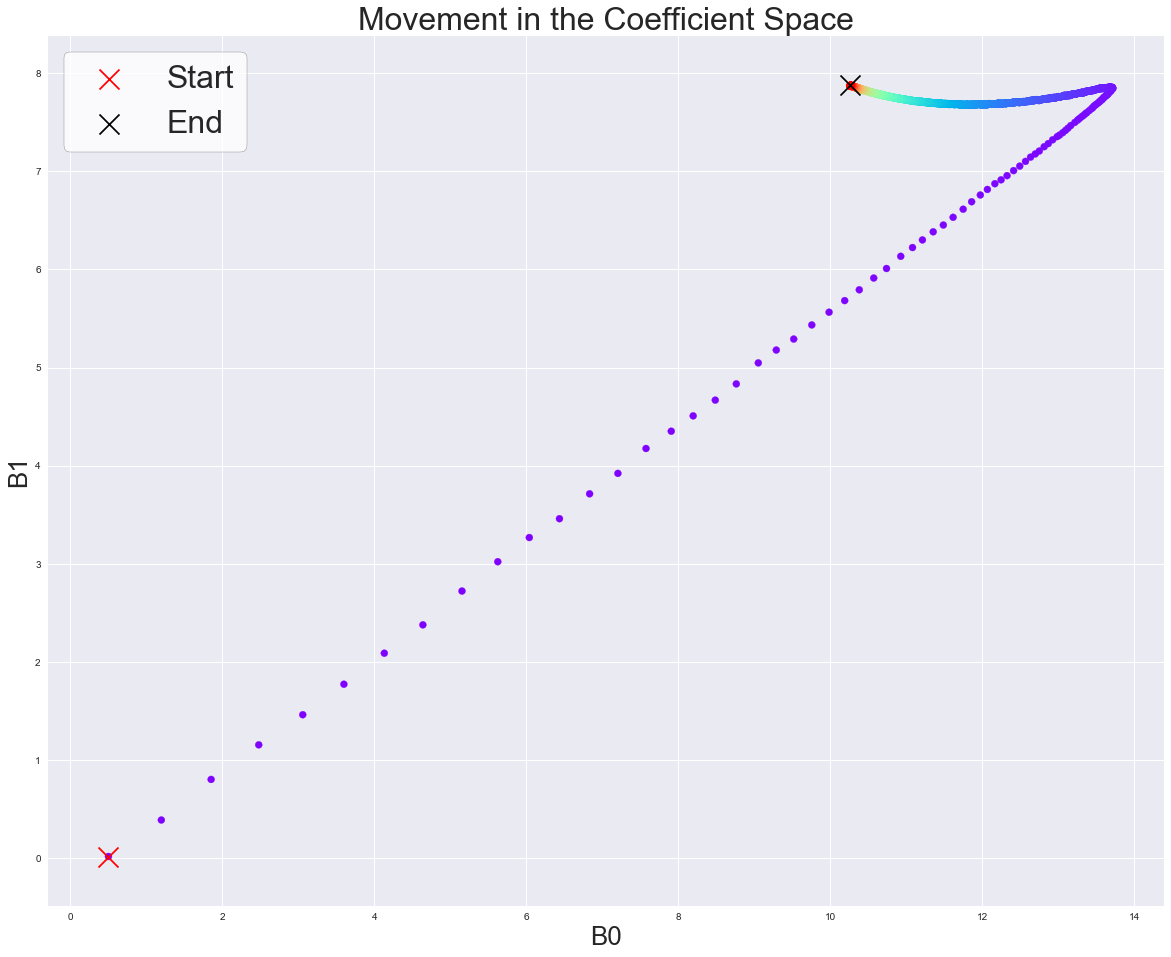

In [20]:
plot_beta_space(steps)

** Now let's look at the last 300 steps. NOTE THE SCALE CHANGE! **

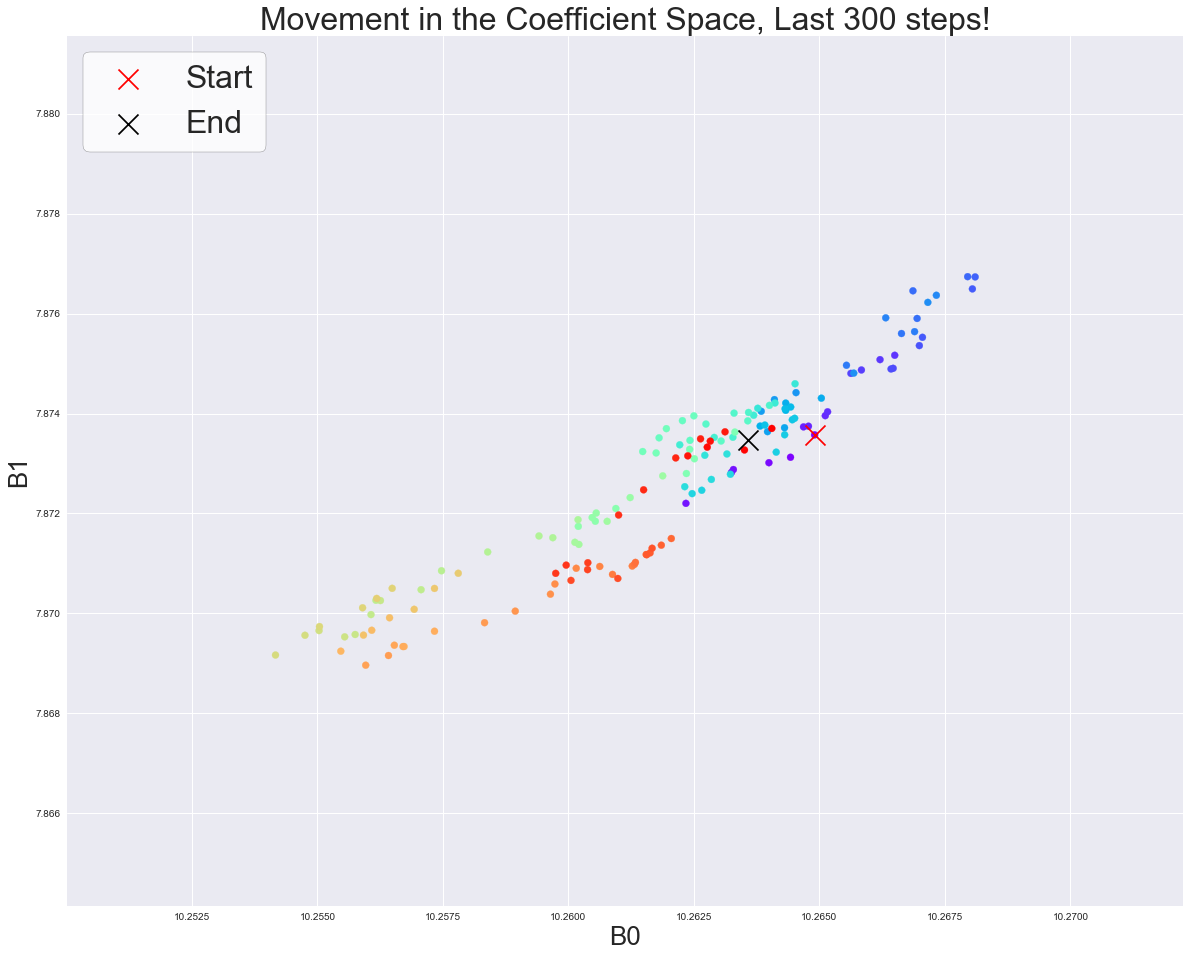

In [21]:
plot_beta_space(steps, last_300=True)

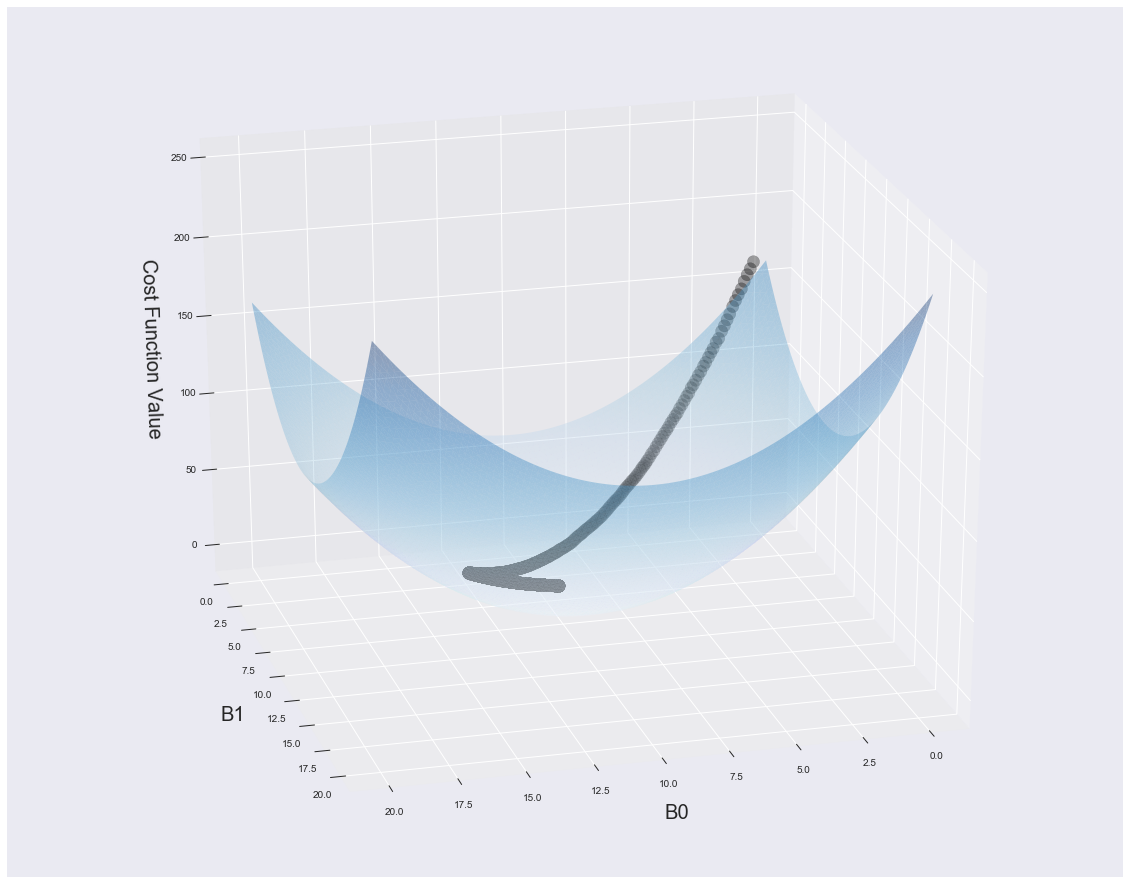

In [22]:
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')

def plot_beta_space3D(steps, components = (0,1)):
    def cost_function(x,y):
        return (x-actual_coefs[components[0]])**2 + (y-actual_coefs[components[1]])**2
    
    plot_vals_x = []
    plot_vals_y = []
    plot_vals_z = []
    for b1 in np.linspace(0,20,100):
        for b2 in np.linspace(0,20,100):
            cost = cost_function(b1,b2)
            plot_vals_x.append(b1)
            plot_vals_y.append(b2)
            plot_vals_z.append(cost)
    
    try:
        B0 = np.array(steps).T[components[0]]
        B1 = np.array(steps).T[components[1]]
    except:
        print("Couldn't find those components, defaulting to (0,1)")
        B0 = np.array(steps).T[0]
        B1 = np.array(steps).T[1]
    
    Z = cost_function(B0, B1)+10
    fig = plt.figure(figsize=(20,16))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(plot_vals_x,plot_vals_y,plot_vals_z, cmap=plt.cm.Blues, linewidth=0.2, alpha=0.4)
    ax.scatter(B0[::5],B1[::5],Z[::5],c='k',s=150);
    ax.set_xlabel("B0", fontsize=20, labelpad=20)
    ax.set_ylabel("B1", fontsize=20, labelpad=20)
    ax.set_zlabel("Cost Function Value", fontsize=20, labelpad=20);
    return ax

ax = plot_beta_space3D(steps)
ax.view_init(25, 75)

# Now let's test with some "real data"

In [23]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [24]:
X = pd.DataFrame(StandardScaler().fit_transform(load_boston().data))
y = pd.DataFrame(load_boston().target)

In [25]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02
mean,6.340997e-17,-6.343191e-16,-2.682911e-15,4.701992e-16,2.490322e-15,-1.145230e-14,-1.407855e-15,9.210902e-16,5.441409e-16,-8.868619e-16,-9.205636e-15,8.163101e-15,-3.370163e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00
min,-4.177134e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990e+00,-2.707379e+00,-3.907193e+00,-1.531127e+00
25%,-4.088961e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-7.675760e-01,-4.880391e-01,2.050715e-01,-7.994200e-01
50%,-3.885818e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-4.646726e-01,2.748590e-01,3.811865e-01,-1.812536e-01
75%,6.248255e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926e+00,8.065758e-01,4.336510e-01,6.030188e-01
max,9.941735e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194e+00,1.638828e+00,4.410519e-01,3.548771e+00


In [36]:
# Simplest form - fit intercept, no dynamic learning for comparison
lasso = lasso_regressor(n_iter=1000, fit_intercept=True, lamb=1e-6)
lasso.fit(X.iloc[:100],y[:100])

In [37]:
lasso.coef_

array([  1.62558780e+01,  -6.62484228e+00,  -1.46256785e-05,
        -1.21808314e+00,  -4.15442425e+00,   1.09499014e+00,
         5.85635916e+00,  -2.09013188e+00,  -4.76252569e-04,
        -9.08772291e-01,  -1.19119955e+00,  -2.64412915e-01,
         1.26118461e+00,  -1.98546147e-01])

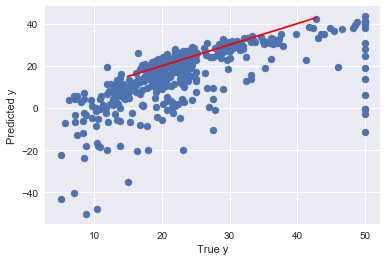

In [38]:
pred = lasso.predict(X.iloc[100:])
plt.scatter(y.iloc[100:], pred, s=50)
temp = np.linspace(min(test_y),max(test_y),100)
plt.plot(temp,temp,'r-')
plt.xlabel("True y")
plt.ylabel("Predicted y");